Welcome to Pset 5! The aim of this problem set is to study different issues that appear when deploying models for real applications. These issues lead to a wide range of societal and ethical issues, some of which this problem set will try to briefly illustrate.

## Logistics

To speed up the execution of the experiments we recommend using GPU acceleration. If you run this notebook on Google Colab, select GPU as your runtime type as follows:

Runtime $\rightarrow$ Change runtime type $\rightarrow$ Hardware accelerator $\rightarrow$ GPU $\rightarrow$ Save.


Training a single model with the default parameters for 40 epochs will take less than 15 minutes using a GPU in Google Colab (which should be available to you for free) or 3.5 hours using a CPU. You should at least train one model for Q1, but the rest of the problem set can be completed either with your model or a model provided by the instructors.

If you get the message: "Notebook requires high RAM", press OK and ignore it.


# Set up environment and download resources



If you want to store data and models in your drive, set the following variable use_gdrive to True, and possibly modify *data_dir* to point to a specific folder. This will allow you to avoid retraining models if your notebook crashes. If set to True, it will ask for permission for the Colab to access your Google Drive.

In [2]:
use_gdrive = False

In [3]:
import os
from tqdm import tqdm

if use_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')

  data_dir = "/content/drive/MyDrive/notebooks_data/Pset5/data"
else:
  data_dir = "./data"

downloads_dir = data_dir + '/downloads'
datasets_dir = data_dir + '/datasets'
models_dir = data_dir + '/models'
pretrained_models = data_dir + '/pretrained_models'
q2c_data_dir = data_dir + '/q2c_data'

os.makedirs(downloads_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(pretrained_models, exist_ok=True)
os.makedirs(q2c_data_dir, exist_ok=True)

mias_dataset_dir = datasets_dir + '/mias_dataset'
external_dataset_dir = datasets_dir + '/external_dataset'

In [4]:
# Download MIAS dataset
!wget http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/mias_dataset.zip -O {downloads_dir}/mias_dataset.zip
!wget http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/external_dataset.zip -O {downloads_dir}/external_dataset.zip
!wget http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/q2c_data.zip -O {downloads_dir}/q2c_data.zip

!unzip -o {downloads_dir}'/mias_dataset.zip' -d {mias_dataset_dir}
!unzip -o {downloads_dir}'/external_dataset.zip' -d {external_dataset_dir}
!unzip -o {downloads_dir}'/q2c_data.zip' -d {q2c_data_dir}

!rm -rf {downloads_dir}

# Download instructors pretrained model
!wget http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/pretreained_models/instructors_model/model.pth -O {pretrained_models}/instructors_model.pth

--2025-02-16 15:57:07--  http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/mias_dataset.zip
Resolving 6.869.csail.mit.edu (6.869.csail.mit.edu)... 128.30.100.221
Connecting to 6.869.csail.mit.edu (6.869.csail.mit.edu)|128.30.100.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22814065 (22M) [application/zip]
Saving to: ‘./data/downloads/mias_dataset.zip’

./data/downloads/mi 100%[===================>]  21.76M  10.5MB/s    in 2.1s    

2025-02-16 15:57:09 (10.5 MB/s) - ‘./data/downloads/mias_dataset.zip’ saved [22814065/22814065]

--2025-02-16 15:57:09--  http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/external_dataset.zip
Resolving 6.869.csail.mit.edu (6.869.csail.mit.edu)... 128.30.100.221
Connecting to 6.869.csail.mit.edu (6.869.csail.mit.edu)|128.30.100.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37122497 (35M) [application/zip]
Saving to: ‘./data/downloads/external_dataset.zip’

./data/downloads/ex 100%[=======

OSError: [Errno 5] Input/output error

# **Problem 1** Train an Image Classifier

Experiment with some of the following hyperparameters, techniques, and model types by modifying the cells that follow:

*   Starting with a pretrained model
*   Data augmentation
*   Weight initialization
*   Dropout
*   Residual connections (ResNet) and dense connections (DenseNet), compared to networks without them (VGGNet, AlexNet)
*   Number of layers, or number of layer features
*   Type of optimizer
*   Learning rate and/or schedule
*   Early stopping



For the rest of the problem set, you can either use your model (save the best performing one) or the one trained by the instructors (which is automatically downloaded in the notebook). If the test performance of your own model is less than **93%**, please use the latter. Note only 90% test performance required for full credit.

## Section 1: Training a Model

This code was adapted from <https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html>

You are free to delete this code entirely and start from scratch, or modify it in whatever way you choose to implement your proposed modifications.

### Dependencies

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# You might not have tqdm, which gives you nice progress bars
# !pip install tqdm
from tqdm.notebook import tqdm
import os
import copy
import pandas as pd
import PIL
import random
from collections import defaultdict

# For reproducibility
torch.manual_seed(1234)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
elif torch.backends.mps.is_available():
    print("Using the GPU (Apple)!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU (Apple)!


### Initialize an Empty Model

First, we need to initialize an empty model, that will input an image, and output a classification. Each model is a little different, so we'll make a helper function that takes in an architecture name, and outputs a model. This is only meant as a guideline, and you can try using different models! `torchvision.models` has other common architectures, and variations on these (like ResNet-50 and ResNet-101), so you may want to try those out.

We also add a `resume_from` argument to specify model weights to load, In case you save a model and want to use it again.

In [6]:
def initialize_model(model_name, num_classes, resume_from = None, use_pretrained = False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0

    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you
    # don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        raise Exception("Invalid model name!")

    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))

    return model_ft, input_size

### Data Loading

With the input size from the model, we can now load the dataset

In [7]:
from torchvision.transforms.functional import to_grayscale

def get_image_transforms():
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.

    # We convert the image to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from the mean/stdev of the ImageNet training set which was used to pretrain our models.

    transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    return transform

def get_dataloaders(dataset_dir, input_size, batch_size, shuffle = True, transform=get_image_transforms()):
    data_transforms = {
        'train': transform,
        'val': transform,
        'test': transform
    }
    # Create training, validation and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_dir, x), data_transforms[x]) for x in data_transforms.keys()}
    # Create training, validation and test dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

### Training
Next, let's make a helper function that trains the given model

In [8]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found,
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    _, preds = torch.max(outputs, 1)

                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                train_acc_history.append(epoch_acc)
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if save_all_epochs:
                torch.save(model.state_dict(), os.path.join(save_dir, f'weights_{epoch}.pt'))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # save and load best model weights
    torch.save(best_model_wts, os.path.join(save_dir, 'weights_best_val_acc.pt'))
    torch.save(model.state_dict(), os.path.join(save_dir, 'weights_last.pt'.format(epoch)))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

### Optimizer & Loss
We need a loss function, and an optimization function to use to try to reduce that loss.

In [9]:
def make_optimizer(model, learning_rate, print_parameters=False):
    # Get all the parameters
    params_to_update = model.parameters()
    if print_parameters:
      print("Params to learn:")
      for name, param in model.named_parameters():
          if param.requires_grad == True:
              print("\t",name)


    optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)
    return optimizer

def get_loss():
    # Create an instance of the loss function
    criterion = nn.CrossEntropyLoss()
    return criterion

### Parameters

Here, we set up some of the various parameters that we can change to run the code. You can add change the values given here, or add new ones! This is just a template.

Our data is conveniently set up to follow the expected format of the  `ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`__
dataset class, rather than writing our own custom dataset.

The ``model_name`` input is the name of the model you wish to use. We've provided starter code that initializes these models using provided models in TorchVision (a PyTorch library)

The code as is supports the following values: [resnet, alexnet, vgg, squeezenet, densenet]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, 3 here, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs (passes through the dataset) we want to run.




In [32]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = "resnet"

# Number of classes in the dataset, normal, benign, malignant
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
num_epochs = 1

# Learning rate
learning_rate =0.01

### IO
# Path to a model file to use to start weights at
resume_from = None

# Whether to use a pretrained model, trained for classification in Imagenet-1k
pretrained = False

# Save all epochs so that you can select the model from a particular epoch
save_all_epochs = False

# Whether to use early stopping (load the model with best accuracy), or not
early_stopping = True

# Directory to save weights to
save_dir = models_dir + '/trained_model_1'
os.makedirs(save_dir, exist_ok=True)

### Tying it all together - Training

In [33]:
# Initialize the model for this run
# train model_1
model_1, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
dataloaders = get_dataloaders(mias_dataset_dir, input_size, batch_size, shuffle_datasets)
criterion = get_loss()

# Move the model to the gpu if needed
model_1 = model_1.to(device)

optimizer_1 = make_optimizer(model_1, learning_rate)

# Train the model!
trained_model_1, validation_history_1, train_history_1 = train_model(model=model_1,
                                                                     dataloaders=dataloaders,
                                                                     criterion=criterion,
                                                                     optimizer=optimizer_1,
                                                                     save_dir=save_dir,
                                                                     save_all_epochs=save_all_epochs,
                                                                     num_epochs=num_epochs)
del model_1, optimizer_1, trained_model_1

Epoch 1/1
----------


  0%|          | 0/77 [00:00<?, ?it/s]

train Loss: 0.5609 Acc: 0.8608


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 0.5093 Acc: 0.8812

Training complete in 2m 39s
Best val Acc: 0.881188


### Load trained models

In [28]:
torch.__version__

'2.6.0'

In [34]:
from torchvision.models.resnet import ResNet
from torch.nn.modules.conv import Conv2d
torch.serialization.add_safe_globals([ResNet])
from torch.nn import BatchNorm2d, Conv2d
torch.serialization.add_safe_globals([BatchNorm2d, Conv2d])
torch.load(pretrained_models + '/instructors_model.pth', weights_only=False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
# Load your final model, that we will use for the rest of the PSET.
if early_stopping:
  weights_file = save_dir + '/weights_best_val_acc.pt'
else:
  weights_file = save_dir + '/weights_last.pt'
model_yours, _ = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

# Move the model to the gpu if needed
model_yours = model_yours.to(device)

# Load weights for model_yours
model_yours.load_state_dict(torch.load(weights_file))

# Load instructors model:
model_inst = torch.load(pretrained_models + '/instructors_model.pth', weights_only=False)
model_inst = model_inst.to(device)

# set models to eval mode
model_yours = model_yours.eval()
model_inst = model_inst.eval()



## Section 2: Inference using a model

Now that we've trained a model, we would like to use it for inference on the test data. We will use a function that can compute top-k performance (i.e., whether the correct prediction is in the top-k predicted classes) but for this problem set, we will set k = 1, as there are only 3 classes.


In [36]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 5):
    # If is_labelled, we want to compute loss, top-1 accuracy and top-5 accuracy
    # If generate_labels, we want to output the actual labels
    # Set the model to evaluate mode
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    gt_labels = []

    # Iterate over data.
    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1)
        # Makes this to calculate "top 5 prediction is correct"
        # [[label1 label1 label1 label1 label1], [label2 label2 label2 label label2]]

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            if is_labelled:
                loss = criterion(outputs, labels)

            # torch.topk outputs the maximum values, and their indices
            # Since the input is batched, we take the max along axis 1
            # (the meaningful outputs)
            _, preds = torch.topk(outputs, k=k, dim=1)
            if generate_labels:
                # We want to store these results
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])
                gt_labels.extend(np.array(labels.cpu()))

        if is_labelled:
            # statistics
            running_loss += loss.item() * inputs.size(0)
            # Check only the first prediction
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            # Check all 5 predictions
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    # Only compute loss & accuracy if we have the labels
    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None

    # Return everything
    return epoch_loss, epoch_top1_acc, gt_labels, predicted_labels

In [37]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
val_loss_yours, val_top1_yours, _, val_labels_yours = evaluate(model_yours, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)
# Get predictions for the test set
test_loss_yours, test_top1_yours, _, test_labels_yours = evaluate(model_yours, dataloaders['test'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)

val_loss_inst, val_top1_inst, _, val_labels_inst = evaluate(model_inst, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)
# Get predictions for the test set
test_loss_inst, test_top1_inst, _, test_labels_inst = evaluate(model_inst, dataloaders['test'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)

print("Your Trained model: ")
print("Val Top-1 Accuracy: {}".format(val_top1_yours))
print("Test Top-1 Accuracy: {}".format(test_top1_yours))

print("Instructors model: ")
print("Val Top-1 Accuracy: {}".format(val_top1_inst))
print("Test Top-1 Accuracy: {}".format(test_top1_inst))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Your Trained model: 
Val Top-1 Accuracy: 0.8811881188118812
Test Top-1 Accuracy: 0.8758169934640523
Instructors model: 
Val Top-1 Accuracy: 0.9636963696369637
Test Top-1 Accuracy: 0.9477124183006536


Select either your model or the instructor model for the next questions. If your model does not achieve high accuracy (at least 93% on the test set), you should use the instructors model (model_inst).

In [39]:
model = model_inst
# model = model_yours

# **Problem 2** Metrics: Accuracy isn't everything

Let's define a function to get detailed evaluation results on the test set.

In [40]:
# Wrapper to easily evaulate a model given a model and the set of dataloaders
def get_eval_results(model, dataloaders):
    model.eval()
    true_label_list = []
    outputs_list = []
    predicted_label_list = []
    original_image_list = []

    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            true_label_list.append(labels)
            original_image_list.append(inputs)
            outputs_list.append(outputs)
            _, preds = torch.topk(outputs, k=1, dim=1)
            predicted_label_list.append(preds)
    return torch.concat(true_label_list).unsqueeze(-1).cpu().numpy(), \
           torch.concat(predicted_label_list).cpu().numpy(), \
           torch.softmax(torch.concat(outputs_list), dim=1).cpu().numpy(), \
           torch.concat(original_image_list).cpu().numpy()

## Please make sure you understand what outputs means here
y_label, y_pred, outputs, inputs =  get_eval_results(model, dataloaders)

  0%|          | 0/10 [00:00<?, ?it/s]


###**(a)** Confusion Matrix

The first simple method that we will use to delve deeper into the results is the confusion matrix. Complete the function below and plot your confusion matrix.


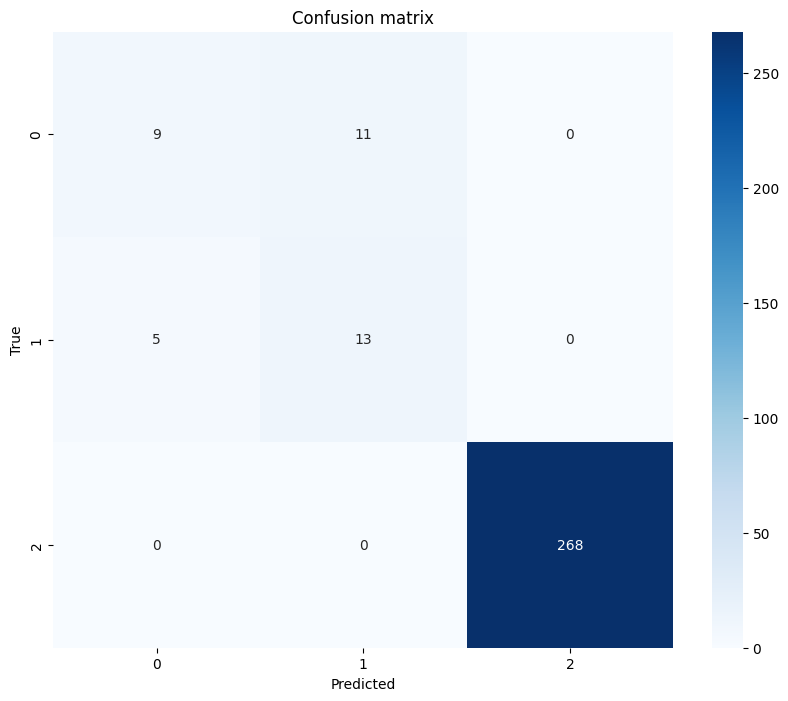

In [41]:
### Complete your code here to plot your confusion matrix.
### Please avoid using sklearn.metrics.confusion_matrix in your function: build your confusion matrix from scratch! You may, however, want to plot its output to check if you're doing the right thing!
### Using helper visualization functions is fine, but don't leave the numbers themselves to sub-packages.
### Feel free to import necessary packages.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(y_label, y_pred, title='Confusion matrix'):
    ### TODO 1
    # Compute confusion matrix
    cm = confusion_matrix(y_label, y_pred)
    
    # Create a figure and axis
    plt.figure(figsize=(10, 8))
    
    # Use seaborn to create a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    
    # Set labels and title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    
    # Show the plot
    plt.show()

plot_confusion_matrix(y_label, y_pred)

###**(b)** Precision-Recall Curve

Assume that the malignant class is our positive class, and the rest are negative classes. In this scenario, a positive prediction happens when our model's prediction for class malignant is *above a user-defined threshold*. That means that a True Positive (TP) happens when we have a positive prediction and the ground truth label is malignant. A False Positive (FP) happens when we have a positive prediction and the ground truth label is something other than malignant. True negatives (TN) and false negatives (FN) follow the same logic.

Remember that Precision = TP/(TP+FP) and Recall = TP/(TP+FN).

**Calculate precision and recall for 1000 evenly spaced thresholds between 0 and 1, and plot the precision-recall curve of your selected model. Then, compute the AUC leveraging the function trapz from numpy, and display the AUC on the plot.** Your output for this question should be one plot, with precision on the Y axis and recall on the X axis.




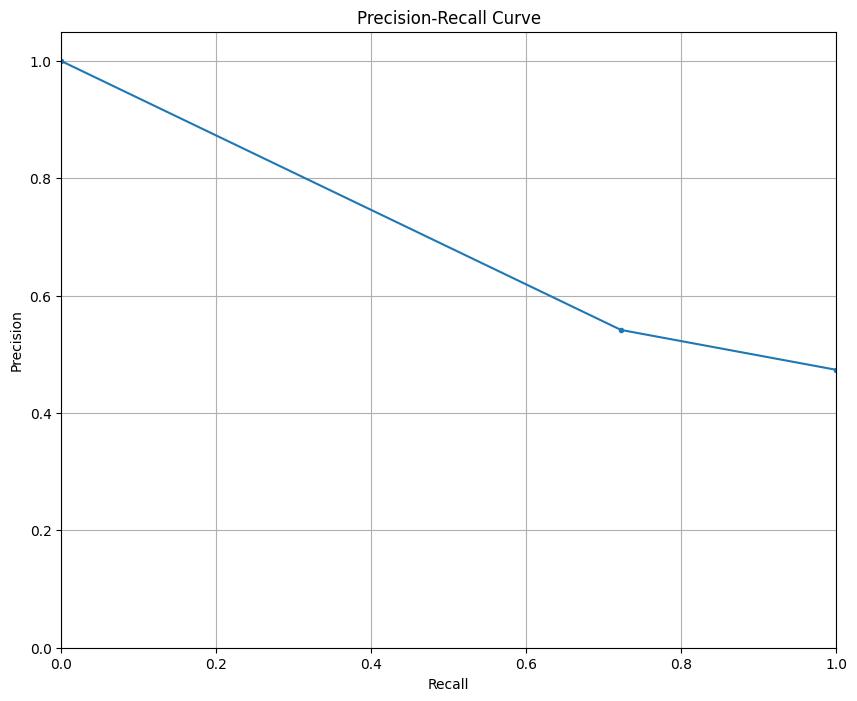

In [43]:
### write your code here to plot your precision-recall curve for the model
### please plot it without using metrics packages here for better understanding

### use the returned values from the get_eval_results() above
### TODO 2
import numpy as np
import matplotlib.pyplot as plt

def plot_precision_recall_curve(y_true, y_scores):
    # Convert to numpy arrays if they're not already
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Get unique thresholds
    thresholds = np.unique(y_scores)
    thresholds = np.sort(thresholds)[::-1]  # Sort in descending order

    precisions = []
    recalls = []

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        
        true_positives = np.sum((y_true == 1) & (y_pred == 1))
        false_positives = np.sum((y_true == 0) & (y_pred == 1))
        false_negatives = np.sum((y_true == 1) & (y_pred == 0))
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 1
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)

    # Plot the precision-recall curve
    plt.figure(figsize=(10, 8))
    plt.plot(recalls, precisions, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(True)
    plt.show()
    
# Assuming get_eval_results() returns y_true and y_scores
plot_precision_recall_curve(y_label, y_pred)

# **Problem 3** What is the model looking at?


In the following code snippet, we use the following pytorch package that implements different variations of CAM:
https://github.com/jacobgil/pytorch-grad-cam


In [44]:
!pip install grad-cam

import random
from collections import defaultdict

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 2.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for ttach from https://files.pythonhosted.org/packages/8d/a3/ee48a184a185c1897c582c72240c2c8a0d0aeb5f8051a71d4e4cd930c52d/ttach-0.0.3-py3-none-any.whl.metadata
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/05/4d/53b30a2a3ac1f75f65a59eb29cf2ee7207ce64867db47036ad61743d5a23/opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 8.4 MB/s eta 0:00:0000:0100:01
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39648 sha256=4c07063225504867a3c5caccaea6446694677b17c15f5404c46f2add7780adf6
  Stored in directory: /Users/suhrid.deshmukh/Library/Caches/pip/wheels/df/e1/fb/84d69cb87032ee4f92e69746bc681

In [55]:
def plot_cams(target_dataloaders, cam_method=GradCAM, class_id='gt'):
  assert class_id in ['gt', 'pred'] or type(class_id) is int and class_id < 3
  for split in ['train', 'val', 'test']:
    target_layers = [model.layer4[-1]]
    fig, axs = plt.subplots(2, 6, figsize=(14, 7))
    fig.suptitle("Examples split {}, class {}".format(split, class_id), fontsize=16)

    split_dataset = target_dataloaders[split].dataset
    indices_per_class = defaultdict(list)
    for i, (_, c) in enumerate(split_dataset.imgs):
      indices_per_class[c].append(i)

    random.seed(1337)
    indices = []
    for c in range(3):
      indices.extend(random.sample(indices_per_class[c], 4))

    for dataset_i, ax in zip(indices, axs.flatten()):
      input_tensor, class_idx = split_dataset[dataset_i]
      # input_tensor = input_tensor[None,...].cuda()
      input_tensor = input_tensor[None,...].to(device)

      # Construct the CAM object once, and then re-use it on many images:
      # cam = cam_method(model=model, target_layers=target_layers, use_cuda=not device == 'cuda')
      cam = cam_method(model=model, target_layers=target_layers)
      pred_class_idx = model(input_tensor).argmax()

      # We have to specify the target we want to generate
      # the Class Activation Maps for
      if type(class_id) is int:
        target_class_id = class_id
      else:
        target_class_id = pred_class_idx if class_id == 'pred' else class_idx
      targets = [ClassifierOutputTarget(target_class_id)]

      # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
      grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

      # In this example grayscale_cam has only one image in the batch:
      grayscale_cam = grayscale_cam[0, :]
      rgb_image = np.array(input_tensor[0].cpu())
      rgb_image = (rgb_image - rgb_image.min())/ (rgb_image.max() - rgb_image.min())
      visualization = show_cam_on_image(rgb_image.transpose((1,2,0)), grayscale_cam, use_rgb=True)

      ax.set_title('True : %s\n Predicted: %s' %(split_dataset.classes[class_idx], split_dataset.classes[pred_class_idx]))
      ax.imshow(visualization)


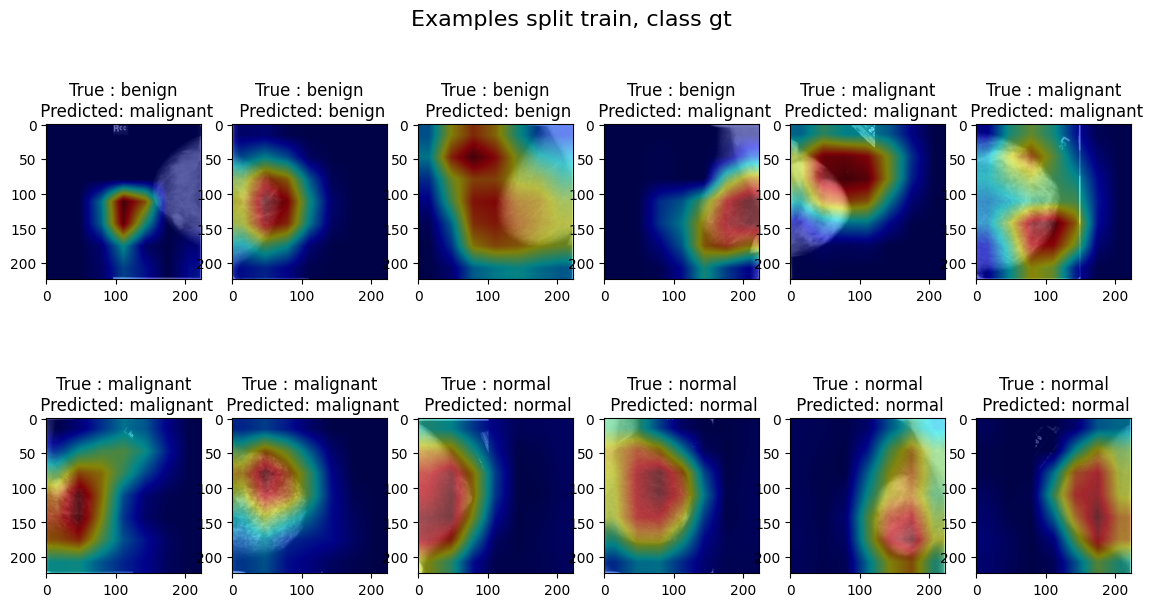

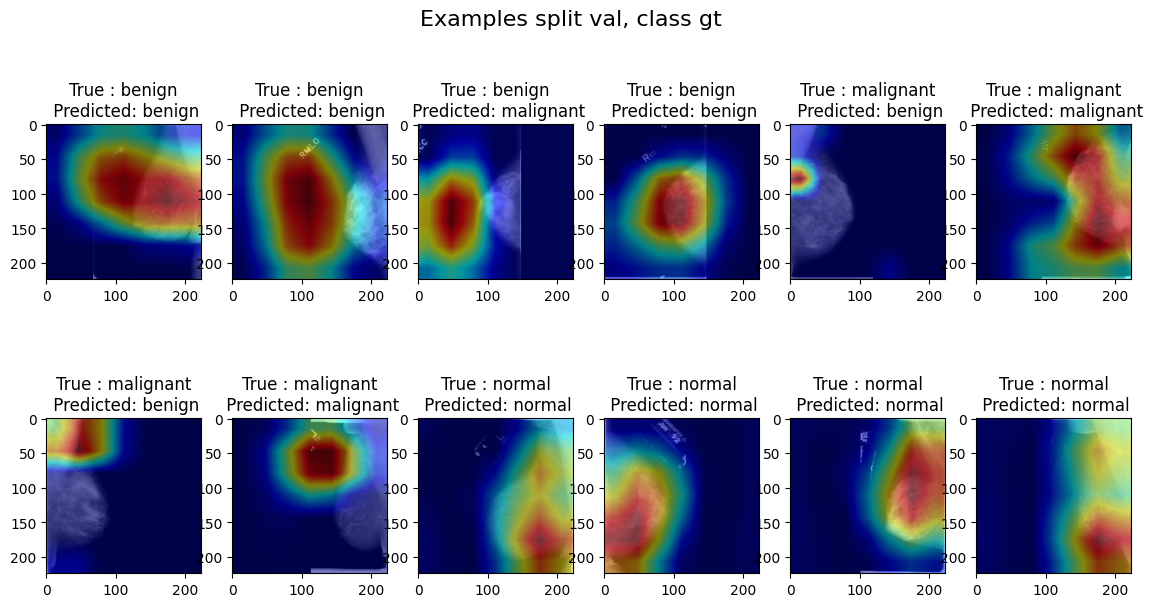

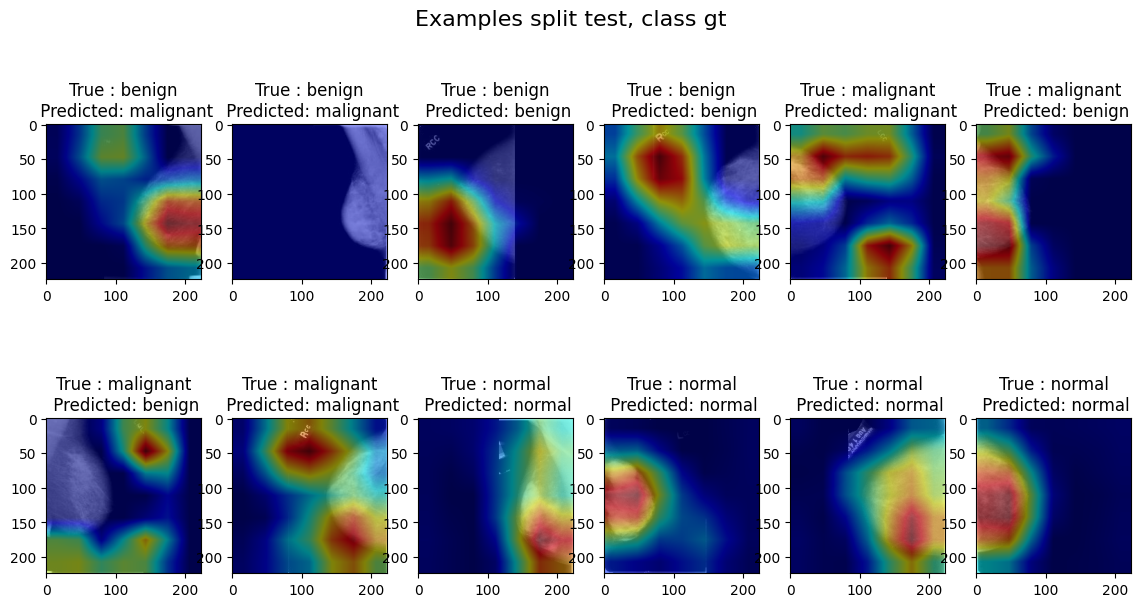

In [56]:
# Substitute GradCAM for one of the following, to test other methods:
# GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# Also substitute class_id for pred, or a class id in [0,1,2] to check different output.
plot_cams(dataloaders, cam_method=GradCAM, class_id='gt')

# Problem 4 Evaluation on an External Dataset


## (a) Compare performances


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Top-1 Acc: 0.9477124183006536
External Top-1 Acc: 0.8790849673202614


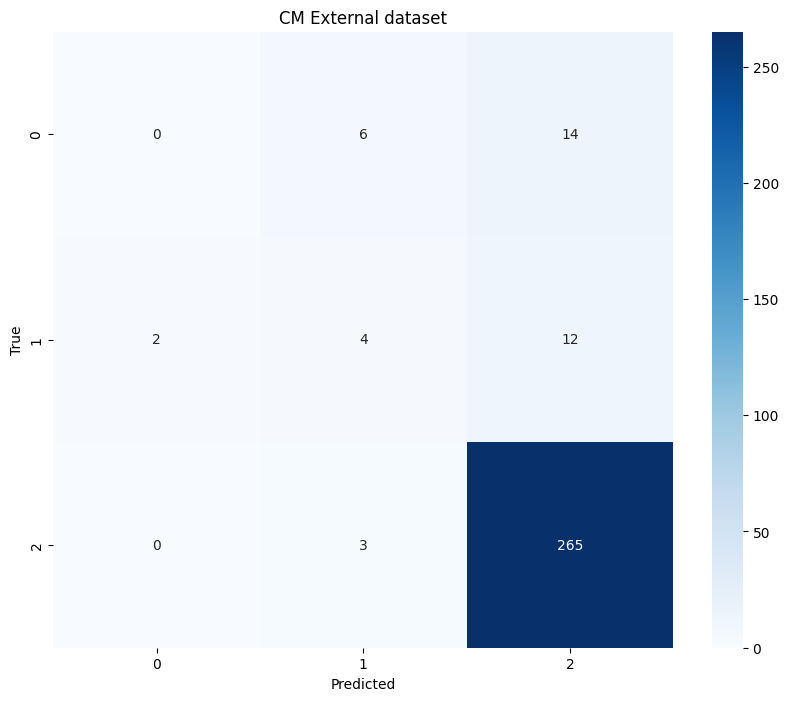

In [47]:
dataloaders_external = get_dataloaders(external_dataset_dir, input_size, batch_size, shuffle_datasets)

test_loss, test_top1, gt_labels, pred_labels = evaluate(model, dataloaders['test'], criterion, is_labelled = True, generate_labels = True, k = 1)
test_loss_ext, test_top1_ext, gt_labels_ext, pred_labels_ext = evaluate(model, dataloaders_external['test'], criterion, is_labelled = True, generate_labels = True, k = 1)

print("Top-1 Acc: {}".format(test_top1))
print("External Top-1 Acc: {}".format(test_top1_ext))

plot_confusion_matrix(gt_labels_ext, pred_labels_ext, title='CM External dataset')


## (b) Compare examples




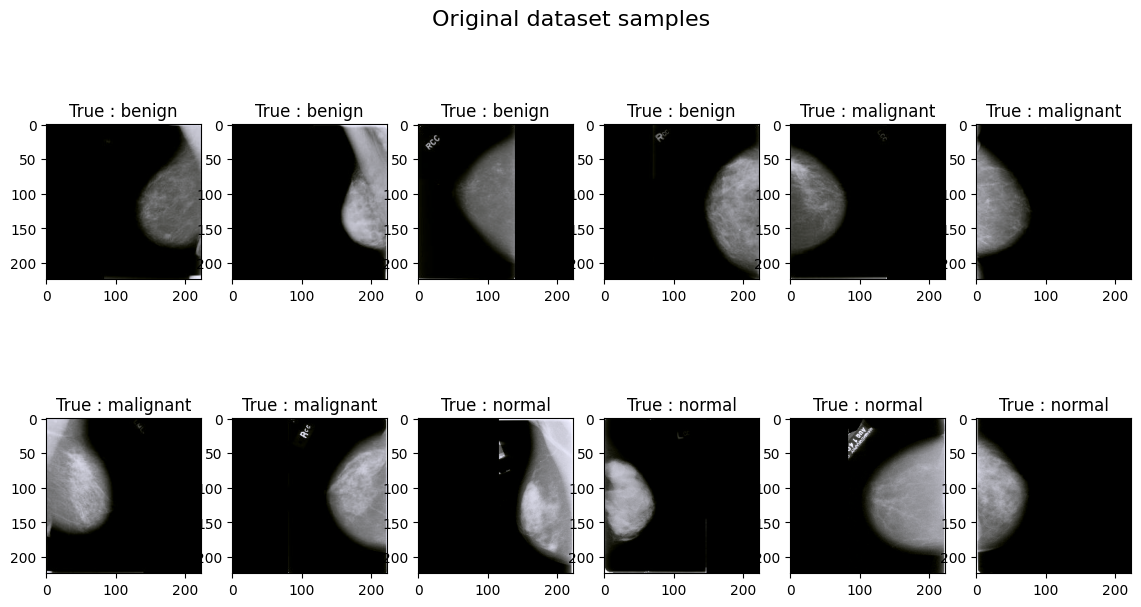

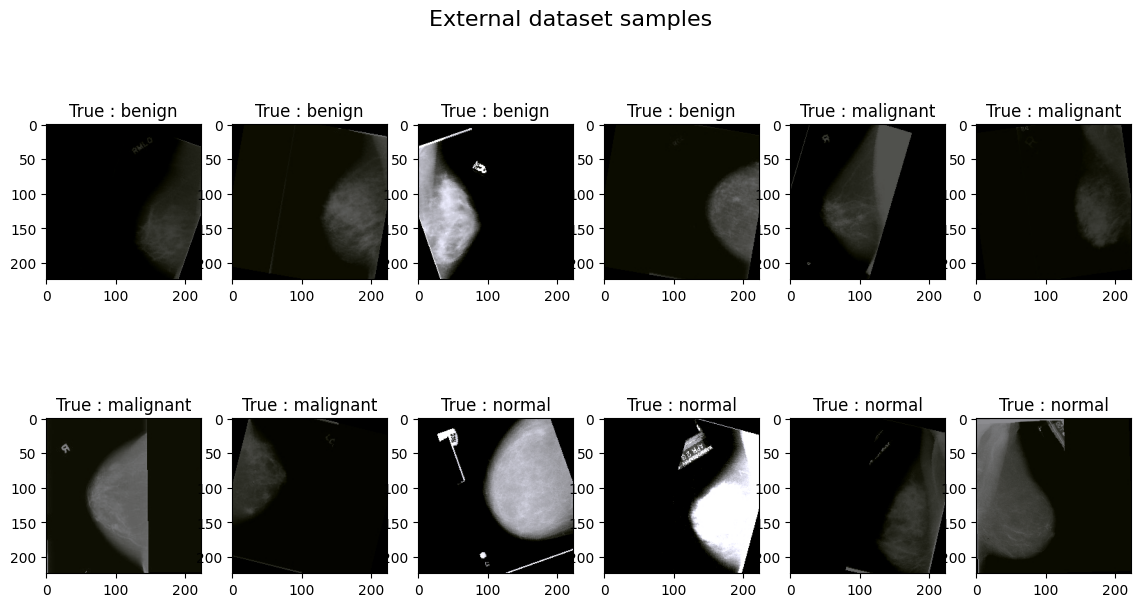

In [57]:
import random
from collections import defaultdict

def plot_samples(dataloaders_external, title=''):
  fig, axs = plt.subplots(2, 6, figsize=(14, 7))
  fig.suptitle(title, fontsize=16)

  dataset = dataloaders_external['test'].dataset
  indices_per_class = defaultdict(list)
  for i, (_, c) in enumerate(dataset.imgs):
    indices_per_class[c].append(i)

  random.seed(1337)
  indices = []
  for c in range(3):
    indices.extend(random.sample(indices_per_class[c], 4))

  # remove normalize transforms for plotting
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
        std=[1/0.229, 1/0.224, 1/0.255]
    )

  for dataset_i, ax in zip(indices, axs.flatten()):
    img, class_idx = dataset[dataset_i]
    img = inv_normalize(img)
    ax.set_title('True : %s' %(dataset.classes[class_idx]))
    if len(img.shape) == 2:
      img = np.tile(img[:,:,None], (1,1,3))
    img = np.array((img*255).clip(0, 255), dtype='uint8')
    ax.imshow(img.transpose((1,2,0)))

# Plot some samples of each of the datasets:
plot_samples(dataloaders, 'Original dataset samples')
plot_samples(dataloaders_external, 'External dataset samples')

## (c) New transformations **[6.8300 only]**
Use some of the available PyTorch transformations in:

https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-and-torch-tensor



In [ ]:
from torchvision.transforms.functional import to_grayscale
# TODO:
external_transforms = transforms.Compose([ # add the transforms here, and run the cell to show the output in your submission


])
# END TODO
transform = transforms.Compose([external_transforms,
                                get_image_transforms()])

modified_original_dataloaders = get_dataloaders(mias_dataset_dir, input_size, batch_size, shuffle_datasets, transform)
plot_samples(modified_original_dataloaders, 'Original dataset samples')
plot_samples(dataloaders_external, 'External dataset samples')

# **Problem 5** Class Imbalance


In [ ]:
from collections import defaultdict
# First we will compute statistics of the dataset:
dataloaders = get_dataloaders(mias_dataset_dir, input_size, batch_size, shuffle_datasets)
train_dataset = dataloaders['train'].dataset

samples_per_class = [0 for _ in range(3)]
for _, class_idx in train_dataset:
  samples_per_class[class_idx] += 1

print("Samples per class:")
for c_idx in range(3):
  print("Class {} ({}): {} samples".format(c_idx, train_dataset.classes[c_idx], samples_per_class[c_idx]))

### **(a)** Loss reweighting

Complete the line of code specified to compute (and print out) the weights per class to balance the class losses.

In [ ]:
total_samples = sum(samples_per_class)

# TODO: Compute the weights per class so that the loss is balanced.
#       We are expecting one weight per class (weights_per_class.shape = [3])
#       If done correctly, the sum of weights over all samples should sum up to total_samples
weights_per_class = ...
# ENDTODO

reweighted_criterion = nn.CrossEntropyLoss(weight=weights_per_class)

# DO NOT REMOVE THIS LINE:
print(weights_per_class)

### **(b)** Dataset rebalancing
Complete the following lines to modify the data loader so that samples for the three classes are balanced. For simplicity, you are allowed to select an element at random, and ignore the *item* argument of the dataset.__getitem__ function.

Then, excecute the training loop with the modified dataset/dataloader and print the number of samples per class in the rebalanced dataset with the code provided

In [ ]:
import random
from collections import defaultdict

class RebalancedDataset(datasets.ImageFolder):
  def __init__(self, class_probabilities, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.class_probabilities = class_probabilities
    self.items_per_class = defaultdict(list)

    for item_i, (_, c) in enumerate(self.imgs):
      self.items_per_class[c].append(item_i)

  def __getitem__(self, i_ignored):
    # ignores argument, and returns an element at random with reweighted class
    if i_ignored >= len(self):
      raise IndexError('Index is too large') # Exception required so that the iterator ends after len(self) samples

    # TODO: select a class at random following self.class_probabilities, and then select a random element for the class
    class_i = ...
    e = ...
    # ENDTODO
    return super().__getitem__(e)


In [ ]:
# Replicates the original get_dataloaders, but in this case we substitute the training dataset for the RebalancedDataset
def get_dataloaders_rebalanced(class_probabilities, dataset_dir, input_size, batch_size, shuffle = True):
    data_transforms = {
        'train': get_image_transforms(),
        'val': get_image_transforms(),
        'test': get_image_transforms()
    }

    # Create training and validation datasets
    image_datasets = {'train': RebalancedDataset(class_probabilities, os.path.join(dataset_dir, 'train'), data_transforms['train']),
                      'val': datasets.ImageFolder(os.path.join(dataset_dir, 'val'), data_transforms['val']),
                      'test': datasets.ImageFolder(os.path.join(dataset_dir, 'test'), data_transforms['test'])}
    # Create training and validation dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

In [ ]:
class_probabilities = [1/3 for _ in range(3)]
dataloaders_rebalanced = get_dataloaders_rebalanced(class_probabilities, mias_dataset_dir, input_size, batch_size, shuffle_datasets)

train_dataset_rebalanced = dataloaders_rebalanced['train'].dataset


In [ ]:
from collections import defaultdict

samples_per_class_rebalanced = [0 for _ in range(3)]
for _, class_idx in tqdm(train_dataset_rebalanced):
  samples_per_class_rebalanced[class_idx] += 1

print("Rebalanced samples per class:")
for c_idx in range(3):
  print("Class {} ({}): {} samples".format(c_idx, train_dataset_rebalanced.classes[c_idx], samples_per_class_rebalanced[c_idx]))



### **(c)** Results of approaches for addressing class imbalance **[6.8300 only]**

Train the models with the modified criterion and rebalanced dataloader by running the next two cells.

In [ ]:
model_reweighted, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

model_reweighted = model_reweighted.to(device)
optimizer_reweighted = make_optimizer(model_reweighted, learning_rate)
trained_reweighted, validation_history_reweighted, train_history_reweighted = train_model(model=model_reweighted,
                                                                                          dataloaders=dataloaders,
                                                                                          criterion=reweighted_criterion,
                                                                                          optimizer=optimizer_reweighted,
                                                                                          save_dir=save_dir,
                                                                                          save_all_epochs=save_all_epochs,
                                                                                          num_epochs=num_epochs)

In [ ]:
model_rebalanced, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

model_rebalanced = model_rebalanced.to(device)
optimizer_rebalanced = make_optimizer(model_rebalanced, learning_rate)
trained_rebalanced, validation_history_rebalanced, train_history_rebalanced = train_model(model=model_rebalanced,
                                                                                          dataloaders=dataloaders_rebalanced,
                                                                                          criterion=criterion,
                                                                                          optimizer=optimizer_rebalanced,
                                                                                          save_dir=save_dir,
                                                                                          save_all_epochs=save_all_epochs,
                                                                                          num_epochs=num_epochs)

Finally, plot the confusion matrix for the three models by running the cell below, and then answer the questions specified in the PDF.


In [ ]:
y_label_reweighted, y_pred_reweighted, _, _ =  get_eval_results(model, dataloaders)
plot_confusion_matrix(y_label_reweighted, y_pred_reweighted, title='CM original')

y_label_reweighted, y_pred_reweighted, _, _ =  get_eval_results(model_reweighted, dataloaders)
plot_confusion_matrix(y_label_reweighted, y_pred_reweighted, title='CM reweighted')

y_label_rebalanced, y_pred_rebalanced, _, _ =  get_eval_results(model_rebalanced, dataloaders)
plot_confusion_matrix(y_label_rebalanced, y_pred_rebalanced, title='CM rebalanced')

**PUT YOUR ANSWERS FOR PROBLEM 5c HERE:**

...